# SETUP

In [1]:
%autosave 0
import sys
sys.dont_write_bytecode = True
from methods import *

Autosave disabled


In [10]:
airsim_map = 'Blocks'
motion = '2d'
home_dir = '/'.join(os.getcwd().split('/')[:-1])+'/'
model_dir = f'{home_dir}models/navigation_airsim_blocks_dqn_2d/'
data_dir = f'{home_dir}data/'
test_dir = f'{model_dir}test_test/'

In [11]:
# astar paths
astar_path = f'{data_dir}astar_paths/v1/{airsim_map}_{motion}_test.p'
astar_paths = pickle.load(open(astar_path, 'rb'))

# config
configuration_path = f'{model_dir}configuration.json'
configuration = json.load(open(configuration_path, 'r'))

# results
results_path = f'{test_dir}evaluation.json'
results = json.load(open(results_path, 'r'))

# states
episodes = read_evaluations(f'{test_dir}states/')[0]

# log txt file from rl_drone
#log_path = working_directory + 'log.txt'
#log = pd.read_csv(log_path, sep=",", header=None, on_bad_lines='skip')[0].tolist() 

# pytorch model
#model_path = working_directory + 'modeling/model_final.zip'
# from stable_baselines3 import DQN as sb3DQN
# mdl = sb3DQN.load(model_path)
# mdl.policy
# from stable_baselines3 import TD3 as sb3TD3
# mdl = sb3TD3.load(model_path)
# mdl.actor

# path accuracy

total test accuracy = 92.45%
average path length relative to A-star = 1.13


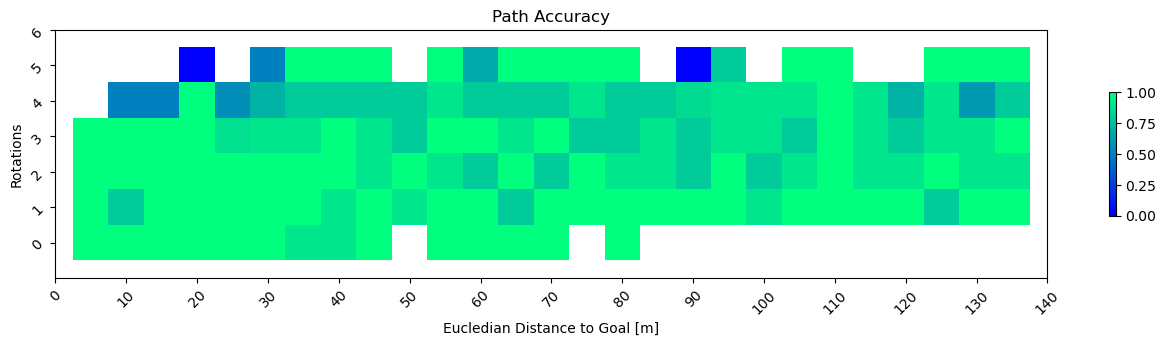

In [8]:
goals = []
path_idxs = []
path_lengths = []
linearities = []
nonlinearities = []
for episode, states in enumerate(episodes):
    initial_step = states[0]
    final_step = states[-1]
    goals.append(final_step['reached_goal'])
    path_idxs.append(initial_step['path_idx'])
    path_lengths.append(len(states))
    linearities.append(initial_step['path_linearity'])
    nonlinearities.append(initial_step['path_nonlinearity'])

# check against astar paths
linearity_bounds = astar_paths['linearity_bounds']
nonlinearity_bounds = astar_paths['nonlinearity_bounds']
goal_map = np.zeros([len(linearity_bounds), len(nonlinearity_bounds)]).astype(float)
total_map = np.zeros([len(linearity_bounds), len(nonlinearity_bounds)]).astype(float)
def get_bin(linearity, nonlinearity):
    for i in range(len(linearity_bounds)-1):
        if linearity < linearity_bounds[i+1]:
            for j in range(len(nonlinearity_bounds)-1):
                if nonlinearity < nonlinearity_bounds[j+1]:
                    return i, j
def get_linearity_idx(linearity):
    for i in range(len(linearity_bounds)-1):
        if linearity < linearity_bounds[i+1]:
            return i
def get_nonlinearity_idx(nonlinearity):
    for j in range(len(nonlinearity_bounds)-1):
        if nonlinearity < nonlinearity_bounds[j+1]:
            return j
test_lengths = []
for idx, path_idx in enumerate(path_idxs):
    path = astar_paths['paths'][path_idx]
    linearity = astar_paths['linearitys'][path_idx]
    nonlinearity = astar_paths['nonlinearitys'][path_idx]
    goal = goals[idx]
    i, j = get_bin(linearity, nonlinearity)
    goal_map[i, j] += goal
    total_map[i, j] += 1
    if goal:
        astar_length = len(path)
        test_length = path_lengths[idx] / astar_length
        test_lengths.append(test_length)
goal_map[total_map <= 0] = np.nan
total_map[total_map <= 0] = np.nan
acc_map = goal_map / total_map
print(f'total test accuracy = {np.round(100*np.mean(goals),2)}%')
print(f'average path length relative to A-star = {np.round(np.mean(test_lengths),2)}')
fig, ax = plt.subplots(figsize=[16,8])
cbar = ax.imshow(acc_map.T, origin='lower', cmap='winter')
fig.colorbar(cbar, shrink=0.2)
plt.title('Path Accuracy')
ax.set_xticks([i for i in range(0, len(linearity_bounds), 2)], [np.round(linearity_bounds[i],2) for i in range(0, len(linearity_bounds), 2)], rotation=45)
ax.set_yticks([i for i in range(0, len(nonlinearity_bounds), 1)], [int(nonlinearity_bounds[i]) for i in range(0, len(nonlinearity_bounds), 1)], rotation=45)
ax.set_xlim([get_linearity_idx(np.min(linearities))-1, get_linearity_idx(np.max(linearities))+1])
ax.set_ylim([get_nonlinearity_idx(np.min(nonlinearities))-1, get_nonlinearity_idx(np.max(nonlinearities))+1])
plt.xlabel('Eucledian Distance to Goal [m]')
plt.ylabel('Rotations')
plt.show()

In [12]:
actions = configuration['components']['Actor']['actions_components'] # list of actions DQN can take
sensor_names = ['DepthV2'] # sensor data to view at each step
sensor_psuedonames = { # names to display in below animation
    'DepthV2':'Reduced Depth Map',
}
resolution = [36, 64] # highest resolution of image data to display [height, width]
id_names = ['alpha'] # id of which data to use (alpha is stable build)

# view data at given episode
episode_idx = 777
episode = episodes[episode_idx]
episode_data, episode_animation = data_at_episode(data_dir, airsim_map, sensor_names, id_names, 
                                      episode, actions, make_animation=True, return_data=True,
                                                 resolution=resolution, 
                                                  sensor_psuedonames=sensor_psuedonames)

# display results
display_data_results(episode_data, episode_animation)

episode_data

collected 10 many data points!
DepthV2 has shape of (10, 1, 36, 64)


{'observations': {'DepthV2': array([[[[255, 255, 255, ..., 255, 255, 255],
           [255, 255, 255, ..., 255, 255, 255],
           [255, 255, 255, ..., 255, 255, 255],
           ...,
           [ 14,  14,  14, ...,  14,  14,  14],
           [ 13,  13,  13, ...,  13,  13,  13],
           [ 13,  12,  12, ...,  12,  12,  13]]],
  
  
         [[[255, 255, 255, ..., 255, 255, 255],
           [255, 255, 255, ..., 255, 255, 255],
           [255, 255, 255, ..., 255, 255, 255],
           ...,
           [ 14,  14,  14, ...,  14,  14,  14],
           [ 13,  13,  13, ...,  13,  13,  13],
           [ 13,  12,  12, ...,  12,  12,  13]]],
  
  
         [[[255, 255, 255, ..., 255, 255,  41],
           [255, 255, 255, ...,  42,  41,  40],
           [255, 255, 255, ...,  42,  41,  40],
           ...,
           [ 14,  14,  14, ...,  14,  14,  14],
           [ 13,  13,  13, ...,  13,  13,  13],
           [ 13,  12,  12, ...,  12,  12,  13]]],
  
  
         ...,
  
  
         [[[255, 